In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import pandas as pd
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import scipy.cluster.hierarchy as sch

In [3]:
import context
from hier_clust import linkage_util, HierClust
from hier_clust.tree_util import Tree

In [4]:
def gen_data(depth, n_dim, depth_labels = None):
    def helper(depth, sigma, offset, path):
        if depth == 0:
            x = np.random.normal(offset, sigma, offset.shape)
            y = 0
            if depth_labels is not None:
                path = path[:depth_labels]
            for digit in path:
                y *= 2
                y += digit
            return x, np.array([y])

        direction = np.random.normal(0, 1, offset.shape)
        direction /= np.linalg.norm(direction)

        x1, y1 = helper(depth - 1, sigma = sigma / 2.0, offset = offset + direction * sigma, path = path + [0])
        x2, y2 = helper(depth - 1, sigma = sigma / 2.0, offset = offset - direction * sigma, path = path + [1])
        
        return np.vstack([x1, x2]), np.concatenate([y1, y2])

    origin = np.zeros((n_dim,))
    return helper(depth, sigma = 1.0, offset = origin, path = [])

In [5]:
def plot_tree_overlay(data, tree, max_depth, dims = None, ax = None):
    if dims is None:
        dims = [0, 1]
    if ax is None:
        fig, ax = plt.subplots()

    def annotate(tree):
        indices = tree.data["orig_indices"]
        tree.data["mean"] = np.mean(data[indices], axis=0)
        for c in tree.children:
            annotate(c)

    def get_lines(tree):
        start = tree.data["mean"][dims]
        lines = []
        for c in tree.children:
            end = c.data["mean"][dims]
            lines.append([start, end])
            lines.extend(get_lines(c))
        return lines

    tree = tree.prune(max_depth)
    annotate(tree)
    lines = mc.LineCollection(get_lines(tree))
    ax.add_collection(lines)

In [6]:
np.random.seed(1)

In [7]:
depth = 11
n_obs = 2 ** depth
n_dim = 10

In [8]:
x, y = gen_data(depth = depth, n_dim = n_dim, depth_labels = 3)

In [9]:
print(x.shape)
print(y.shape)

(2048, 10)
(2048,)


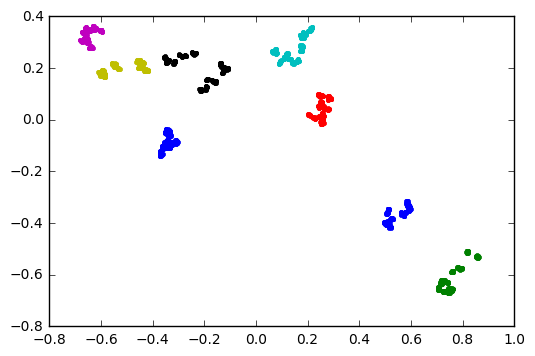

In [10]:
fig, ax = plt.subplots()
for yi in np.unique(y):
    ax.plot(x[y == yi, 0], x[y == yi, 1], '.')
None

In [11]:
%%time
hc = HierClust(n_neighbors=200, neighbor_graph_strategy='balltree')
t2, _ = hc.fit(x)

CPU times: user 17.1 s, sys: 368 ms, total: 17.5 s
Wall time: 17.5 s


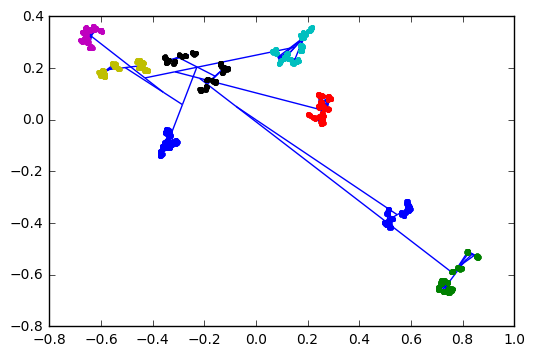

In [12]:
fig, ax = plt.subplots()
for yi in np.unique(y):
    ax.plot(x[y == yi, 0], x[y == yi, 1], '.')
plot_tree_overlay(data = x, tree = t2, max_depth = 10, ax = ax)

None

In [13]:
# link2 = linkage_util.get_linkage(t2)
# sch.dendrogram(link2)
# None

In [14]:
%%time
link = sch.linkage(x, method='complete')

CPU times: user 57.2 ms, sys: 18.6 ms, total: 75.8 ms
Wall time: 75.4 ms


In [15]:
t = linkage_util.linkage_to_tree(link)

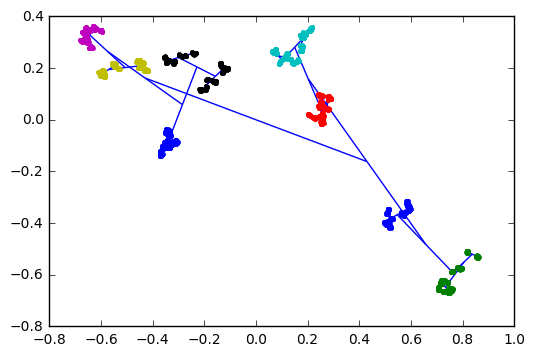

In [16]:
fig, ax = plt.subplots()
for yi in np.unique(y):
    ax.plot(x[y == yi, 0], x[y == yi, 1], '.')
plot_tree_overlay(data = x, tree = t, max_depth = 10, ax = ax)

None